# Implementation of Frequency Methods
Following functions are implemented:
- Calulate derivative with FFT
- Calculate extension of a function(one and multidimensional)
- Calculate derivative with FFT and extension of a function

In [1]:
# Packages
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.linalg
import itertools
import pysindy as ps

from scipy.optimize import minimize
from scipy.fft import fftn, ifftn, fftfreq,fft

### Functions for calculating derivative and extension

In [2]:
# Calculates the spectral derivative for n-dimensional input and order
# Takes ax and d as liste e.g. ax = [0], d =[0.1]
def calc_deriv_fftn(f,ax,d):
    if isinstance(ax, list) == False or isinstance(ax, list) == False:
        print("ax and d are only valid as a list")
        print("Exit calc_deriv_fftn")
        return None
    order = len(ax)
    fftf = fftn(f)
    frequencies = []
    # Calculate frequencies
    for i in range(order):
        frequencies.append(fftfreq(f.shape[ax[i]],d[i]))

    #Expand frequencies so we can  multiply
    for j in range(order):
        liste = list(range(f.ndim)) 
        liste.remove(ax[j])
        for i in liste:
            frequencies[j] = np.expand_dims(frequencies[j],axis=i)
            frequencies[j] = np.repeat(frequencies[j],f.shape[i],axis=i)
        fftf *=2*np.pi*1j*frequencies[j]
    return ifftn(fftf).real


def create_data_2d(T_start, T_end, L_x, N_t, N_x):
    t = np.linspace(T_start, T_end, num=N_t)
    x = np.linspace(-L_x/2.0, L_x/2.0, num=N_x)
    T,X = np.meshgrid(t,x)
    return T,X,t,x

def create_data_3d(T_start, T_end, L_x,L_y, N_t, N_x,N_y):
    t = np.linspace(T_start, T_end, num=N_t)
    x = np.linspace(-L_x/2.0, L_x/2.0, num=N_x)
    y = np.linspace(-L_y/2.0, L_y/2.0, num=N_y)
    T,X,Y = np.meshgrid(t,x,y)
    return T,X,Y,t,x,y

In [3]:
# This function takes f and x, creates more datapoints s.t. f 
# can be extended to a periodic function with value 0 at end and beginning
# return newf, newx, newn, only works for one_dim function
def flattenandextendfunc_1d(f,x):
    # error handling
    if f.size!=x.size:
        print("Error: f and x do not have same size: f.size="
              +str(f.size)+",x.size="+str(x.size))
        print("Exit flattenandextendfu")
        return None
    # Get necessary data to extend f
    dx = x[1]-x[0]
    A=x[0]
    B=x[x.size-1]
    n=max(int(x.size/10),20) 
    # Create new data
    newx=np.arange(A-n*dx,B +n*dx,dx)
    newf=np.empty(newx.size, dtype=float)
    oldf=newf.copy()
    # Get slope at beg and end
    slope_start = (f[1]-f[0])/dx
    slope_end = (f[f.size-1]-f[f.size-2])/dx
    # Extend oldf
    oldf[n:n+f.size]=f
    oldf[n+f.size:]=slope_end*dx*np.arange(1, oldf[n+f.size:].size+1)+f[f.size-1]
    oldf[:n]=f[0]-slope_start*dx*np.arange(1, oldf[:n].size+1)[::-1] #[::-1] means reverse array
    # Create newf: in the middle equal to f, continuous extension such that 
    # start and endpoint are equal to one
    a=30
    half = A+(B-A)/2
    newf[newx<=half]=1.0/(1.0 + np.exp(-a*(newx[newx<=half]-(A-n/2*dx))))
    newf[newx>half]=-1.0/(1.0 + np.exp(-a*(newx[newx>half]-(B+n/2*dx))))+1.0
    newf = newf*oldf
    return newf,newx,n

def getnewsize(x):
    dx = x[1]-x[0]
    A=x[0]
    B=x[x.size-1]
    n=max(int(x.size/10),20) 
    newx=np.arange(A-n*dx,B +n*dx,dx)
    return newx.size

# Extends multidimensional function
def flattenandextendfunc_nd(f,inp):
    dim = f.ndim # get dimension
    newsize=[getnewsize(myinp) for myinp in inp]
    n=[]
    newinp=inp.copy()
    temp=[]
    liste = list(range(dim))
    # Iterate through axis: extend function for selected axis
    for axis in liste:
        liste_drop = liste.copy()
        liste_drop.remove(axis)
        
        # Calculate new shape
        shape = list(f.shape)
        shape[axis]=newsize[axis]
        shape = tuple(shape)
        temp = np.zeros(shape) #Create array with new extended shape

        start = np.zeros(dim, dtype=int) #for slicing
        end = np.zeros(dim, dtype=int)+f.shape[axis] # for slicing
        newend = np.zeros(dim, dtype=int)+newsize[axis] #for slicing new array

        # Select and save ranges in rangelist for iterating
        rangelist =[]
        for otheraxis in liste_drop:
            rangelist.append(range(f.shape[otheraxis]))  

        #Extend function for axis
        for J in itertools.product(*rangelist):
            i=0
            #Calculate slice
            for otheraxis in liste_drop:
                start[otheraxis] = J[i]
                end[otheraxis]=J[i]+1
                newend[otheraxis] = end[otheraxis]
                i+=1
            myslice =tuple(slice(*indexes) for indexes in zip(start, end))
            newslice =tuple(slice(*indexes) for indexes in zip(start, newend))

            #Extend one dimensional version
            col, newinp_axis, n_axis =flattenandextendfunc_1d(f[myslice].ravel(),newinp[axis])
            temp[newslice] = col.reshape(temp[newslice].shape)

        f = temp #Set f equal to temp    
        # Save new Input and new numbers f data
        newinp[axis]=newinp_axis
        n.append(n_axis)

    return f,newinp,n

### Calculate derivative with FFT and extension of a function

In [4]:
# inp list of arrays: e.g. inp = [x,t]
# u function to be differentiated
# axis decides which value should be differentiated
def calc_deriv_fftn_with_ext(u,inp,axis,dist):
    #Extension
    newu,newinp,n = flattenandextendfunc_nd(u,inp)
    #Define slice to get right values from extension
    start = n
    end = [sum(x) for x in zip(n, list(u.shape))] #end = n0+u.shape[0],n1+u.shape[1],...
    myslice =tuple(slice(*indexes) for indexes in zip(start, end))
    #Derivative 
    ux = calc_deriv_fftn(newu,axis,dist)
    ux = ux[myslice]
    return ux,newu,myslice

In [5]:
a = 1
b = 2
nx, nt = (300, 200)
x = np.linspace(0, 10, nx)
t = np.linspace(0, 10, nt)
tv, xv = np.meshgrid(t, x)

#u = (xv + b*tv) * np.exp(a*tv)
u= np.exp(xv-a*tv)
dx = x[1] - x[0]
ux = ps.FiniteDifference(d=1, axis=0,drop_endpoints=False)._differentiate(u, dx)
ux_noise_myfft,newu,myslice = calc_deriv_fftn_with_ext(u,[x,t],[0],[dx])

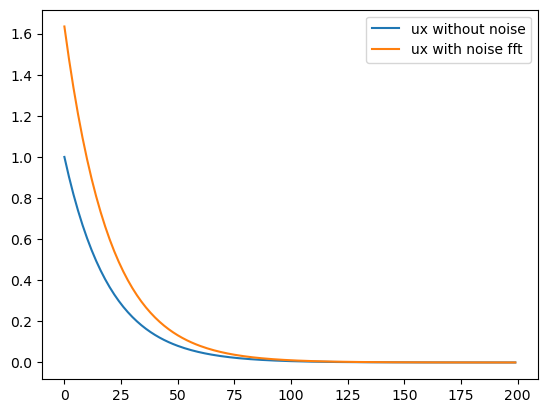

In [8]:
plt.plot(ux[0],label='ux without noise')
#plt.plot(ux_noise[0][:n],label='ux with noise finite differences')
#plt.plot(ux_noise_sindy[0][:n],label='ux with noise sindy')
plt.plot(ux_noise_myfft[0],label='ux with noise fft')
plt.legend()
plt.show()

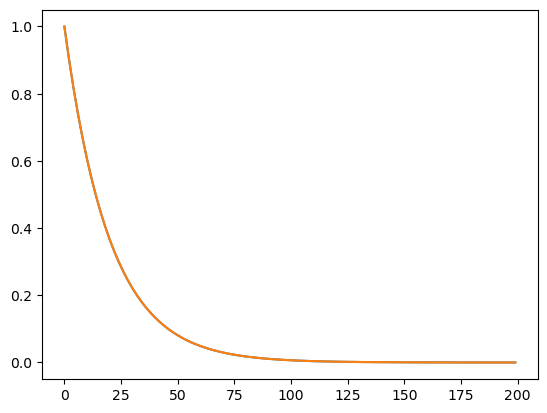

In [7]:
plt.plot(ux[0])
plt.plot(newu[myslice][0])

In [19]:
n_samples=20
n_input=2
x1 = 20 * np.random.randn(n_samples, n_input) - 10
def func(x, module): 
    if module == sympy:
        x0 = sympy.Symbol('x0')
        x1 = sympy.Symbol('x1')
    else:
        x0 = x[:, 0]
        x1 = x[:, 1]
    return module.exp(x0-a*x1)

In [20]:
 n_input = 2
x = np.linspace(0, 10, nx)
t = np.linspace(0, 10, nt)
tv, xv = np.meshgrid(t, x)
def func2(x, module): 
    if module == sympy:
        x0 = sympy.Symbol('x0')
        x1 = sympy.Symbol('x1')
    else:
        x0 = x[:, 0]
        x1 = x[:, 1]
    return module.exp(xv-a*tv)

In [21]:
func(x1,np)

NameError: name 'sympy' is not defined

In [24]:
xt = 20 * np.random.randn(n_samples, n_input)
x0 = xt[:, 0]
x1 = xt[:, 1]
f=np.exp(x0-a*x1)
f.shape

(20,)

In [27]:
x = np.linspace(0, 10, n_samples)
t = np.linspace(0, 10, n_samples)
tv, xv = np.meshgrid(t, x)
f = np.exp(xv-a*tv)
f.shape

(20, 20)

In [29]:
a,b = np.random.randn(2)

In [30]:
a

0.35652374210078264

In [31]:
b

-1.7254378552563223